# UFRN Constructions's Finances
On this NoteBook we will present our discoveries over constructions and investments all over UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE ([UFRN](www.ufrn.br)).
All this made as a project for a subject on UFRN called `PROBABILIDADE`, where we choose some of several available open data about our university.

## Choosen Data
We decided to work over some financial values at UFRN, like how much money cost a specific work, how long it generally takes to finish a construction, the most expensive work, and so on. For that, we used the following 'csv' files:
- [obras.csv](http://dados.ufrn.br/dataset/a8b897f9-4659-44d4-842e-ac70ae21eb83/resource/067e7cad-934c-4134-a5d5-807915c074b4/download/obras.csv)
- [requisicaoobras.csv](http://dados.ufrn.br/dataset/15f55d0c-7ac8-4c1e-a73c-b0e37b9ef873/resource/0d923d18-1ffa-41d7-972f-33a12e9daf62/download/requisicaoobras.csv)

Importing some useful libs

In [0]:
!pip install -q plotly_express

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px
import plotly 
plotly.tools.set_credentials_file(username='ozielalves', api_key='tbvRq28Pi5iHHYWq7vWK')

Just reading and showing the dataframe we are about to work with.

In [0]:
works = pd.read_csv("obras.csv", sep=';')
work_requests = pd.read_csv("requisicaoobras.csv", sep=';', parse_dates=['data_envio'])

#### Works Data Frame

In [4]:
print(works.info())
works.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 14 columns):
id_obra                   846 non-null int64
descricao                 846 non-null object
periodo                   846 non-null object
qtd_dias                  846 non-null int64
status_obra               846 non-null object
licitacao                 846 non-null object
empresa                   846 non-null object
modalidade                846 non-null object
valor                     846 non-null object
fonte_recurso             554 non-null object
vigencia_projeto          337 non-null object
projeto                   337 non-null object
id_unidade_responsavel    473 non-null float64
unidade_responsavel       473 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 92.6+ KB
None


,id_obra,descricao,periodo,qtd_dias,status_obra,licitacao,empresa,modalidade,valor,fonte_recurso,vigencia_projeto,projeto,id_unidade_responsavel,unidade_responsavel
0,848,CONSTRUÇÃO DO SETOR DE ANTIBIÓTICOS PRODUÇÃO D...,02/06/2005 - 29/01/2006,240,FINALIZADA,4/2004,03.722.669/0001-85 - CONSTRUTORA CAGEO LTDA,CONCORRÊNCIA,"R$ 1.561.230,93",TESOURO - EDUCAÇÃO (112000000),NaN,NaN,252.0,NUCLEO DE PESQUISA EM ALIMENTOS E MEDICAMENTOS
1,521,CONSTRUÇÃO DO BLOCO A1 DO SETOR DE AULAS TEÓRI...,04/05/2005 - 30/12/2005,240,FINALIZADA,7/2004,03.166.687/0001-28 - CRS-CONSTRUÇÕES E EMPREE...,CONCORRÊNCIA,"R$ 833.702,12",NaN,20/04/2005 - 20/11/2005,19O ENECIC/2005 (852005),NaN,NaN
2,493,CONSTRUÇÃO DO BLOCO H DO SETOR DE AULAS TEÓRIC...,23/03/2005 - 19/11/2005,240,FINALIZADA,6/2004,03.166.687/0001-28 - CRS-CONSTRUÇÕES E EMPREE...,CONCORRÊNCIA,"R$ 829.454,21",NaN,NaN,NaN,NaN,NaN
3,925,Complementação da 2ª Etapa e Realização da 3ª ...,28/01/2005 - 22/01/2006,360,FINALIZADA,2/2004,40.761.454/0001-08 - AR PROJETOS & CONSTRUÇÕE...,CONCORRÊNCIA,"R$ 814.550,74",NaN,20/12/2002 - 31/07/2007,UFRN/CONV.133/02 - HUOL (862003),446.0,HOSPITAL UNIVERSITÁRIO ONOFRE LOPES
4,478,CONSTRUÇÃO DO BLOCO H DO SETOR DE AULAS TEÓRIC...,23/03/2005 - 19/11/2005,240,FINALIZADA,5/2004,03.166.687/0001-28 - CRS-CONSTRUÇÕES E EMPREE...,CONCORRÊNCIA,"R$ 847.582,26",APLICACOES FINANCEIRAS (280154215),NaN,NaN,NaN,NaN


#### Work Requests Data Frame

In [5]:
print(work_requests.info())
work_requests.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6530 entries, 0 to 6529
Data columns (total 12 columns):
numero                       6530 non-null int64
ano                          6530 non-null int64
id_unidade_requisitante      6530 non-null int64
nome_unidade_requisitante    6530 non-null object
id_unidade_custo             6530 non-null int64
nome_unidade_custo           6530 non-null object
data_envio                   4175 non-null datetime64[ns]
descricao                    6530 non-null object
local                        3636 non-null object
observacoes                  1151 non-null object
status                       6530 non-null object
processo                     4938 non-null object
dtypes: datetime64[ns](1), int64(4), object(7)
memory usage: 612.3+ KB
None


,numero,ano,id_unidade_requisitante,nome_unidade_requisitante,id_unidade_custo,nome_unidade_custo,data_envio,descricao,local,observacoes,status,processo
0,7051,2018,52,DEPARTAMENTO DE ENGENHARIA CIVIL,52,DEPARTAMENTO DE ENGENHARIA CIVIL,2018-09-19,Novo dimensionamento de extintores de incêndio...,prédio do LARHISA.,NaN,AUTORIZADA PARA INFRA,NaN
1,7050,2018,1463,RESIDENCIAS UNIVERSITÁRIAS,1463,RESIDENCIAS UNIVERSITÁRIAS,2018-09-19,Solicitamos por gentileza a revisão geral na r...,Residência Universitária Biomédica.,NaN,PENDENTE AUTORIZAÇÃO CHEFE UNIDADE,NaN
2,7007,2018,8031,PROAD - DIRETORIA DE GESTÃO DA INFORMAÇÃO,1422,PRÓ-REITORIA DE ADMINISTRAÇÃO (PROAD),2018-09-18,De acordo com o Relatório de Inspeção de Segur...,ARQUIVO GERAL,NaN,AUTORIZADA PARA INFRA,NaN
3,6934,2018,20,SUPERINTENDÊNCIA DE INFRAESTRUTURA,9160,MANUTENÇÃO E CONSERVAÇÃO DA INFRA-ESTRUTURA FÍ...,2018-09-14,RECUPERAÇÃO ESTRUTURAL DA CAPELA ECUMÊNICA DO ...,CAPELA ECUMÊNICA DO CAMPUS CENTRAL,"RDC 11/2018 - R$ 95.436,38",FINALIZADA_ATENDIMENTO,NaN
4,6763,2018,62,ADMINISTRAÇÃO DO CERES - CURRAIS NOVOS,9170,MANUTENÇÃO DA REDE ELÉTRICA,2018-10-09,SERVIÇOS DE ILUMINAÇÃO DO ESTACIONAMENTO DO CE...,ESTACIONAMENTO DO CERES - CURRAIS NOVOS/RN,"RDC 12/2018 - R$ 111.444,99",FINALIZADA_ATENDIMENTO,NaN


## Obs.:
Unfortunately, the `data_envio` column, which is referent to when the request were submitted has null elements. Because of that, our inicial ideia of using this column as a `DateTimeIndex` has been destroyed.

### 1 ) Cleaning all unlabeled data
We choose to discharge those informations which had no unit responsible for the infrastructure work.
As a matter of fact, we have 473 infrastructure works with a responsible unit described (out of 846).

In [48]:
valid_indexes = []
for idx, isnull in enumerate(works['unidade_responsavel'].isnull()):
    if (isnull == False ):
        valid_indexes.append(idx)

# Getting only valid data and re-index this new dataframe, since lots of datas would be excluded
works_filter = works.iloc[valid_indexes].reset_index(drop=True)
works_filter

,id_obra,descricao,periodo,qtd_dias,status_obra,licitacao,empresa,modalidade,valor,fonte_recurso,vigencia_projeto,projeto,id_unidade_responsavel,unidade_responsavel
0,848,CONSTRUÇÃO DO SETOR DE ANTIBIÓTICOS PRODUÇÃO D...,02/06/2005 - 29/01/2006,240,FINALIZADA,4/2004,03.722.669/0001-85 - CONSTRUTORA CAGEO LTDA,CONCORRÊNCIA,"R$ 1.561.230,93",TESOURO - EDUCAÇÃO (112000000),NaN,NaN,252.0,NUCLEO DE PESQUISA EM ALIMENTOS E MEDICAMENTOS
1,925,Complementação da 2ª Etapa e Realização da 3ª ...,28/01/2005 - 22/01/2006,360,FINALIZADA,2/2004,40.761.454/0001-08 - AR PROJETOS & CONSTRUÇÕE...,CONCORRÊNCIA,"R$ 814.550,74",NaN,20/12/2002 - 31/07/2007,UFRN/CONV.133/02 - HUOL (862003),446.0,HOSPITAL UNIVERSITÁRIO ONOFRE LOPES
2,182,CONSTRUÇÃO DO DEPARTAMENTO DE FISIOTERAPIA - CCS,08/02/2006 - 02/02/2007,360,FINALIZADA,1/2005,01.694.415/0001-75 - HASTE-HABITAÇÃO E SERVIÇ...,CONCORRÊNCIA,"R$ 1.455.865,61",NaN,20/12/2004 - 30/03/2010,CONVENIO 121/2004 UFRN (732005),446.0,HOSPITAL UNIVERSITÁRIO ONOFRE LOPES
3,282,ADAPTAÇÃO DE AMBIENTES DE ENSINO NO HOSPITAL U...,11/09/2006 - 08/05/2007,240,FINALIZADA,1/2006,04.145.787/0001-30 - ECCL - EMPREENDIMENTOS E...,CONCORRÊNCIA,"R$ 1.153.423,68",NaN,20/12/2005 - 31/12/2011,FUNPEC/UFRN/CONV. 134/2005 - EMENDA PARLAMENTA...,446.0,HOSPITAL UNIVERSITÁRIO ONOFRE LOPES
4,5778,COMPLEMENTAÇÃO DA CONSTRUÇÃO DA 1ª ETAPA DO PA...,05/03/2010 - 02/08/2010,150,FINALIZADA,3/2007,04.145.787/0001-30 - ECCL - EMPREENDIMENTOS E...,CONCORRÊNCIA,"R$ 967.866,36",NaN,20/12/2005 - 31/12/2011,FUNPEC/UFRN/CONV. 134/2005 - EMENDA PARLAMENTA...,441.0,CENTRO DE CIÊNCIAS DA SAÚDE
5,2419,CONSTRUÇÃO DO PAVILHÃO ACADÊMICO DO CAMPUS AVA...,10/08/2007 - 04/06/2008,300,FINALIZADA,2/2007,04.201.519/0001-99 - ESTRUTURAL EDIFICAÇÕES E...,CONCORRÊNCIA,"R$ 1.248.942,91",NaN,23/01/2006 - 23/06/2010,FINEP/REDE 01 GEOFISICA DA EXPLORACAO/FASE 2 -...,1646.0,CAMPUS AVANÇADO DE SANTA CRUZ
6,3217,CONSTRUÇÃO DO NÚCLEO DE PROCESSAMENTO PRIMÁRIO...,18/02/2008 - 13/05/2009,450,FINALIZADA,4/2007,04.145.787/0001-30 - ECCL - EMPREENDIMENTOS E...,CONCORRÊNCIA,"R$ 2.833.577,19",TESOURO - EDUCAÇÃO (112000000),21/09/2006 - 03/09/2013,FUNPEC/CENPES/LTPP (1912006),605.0,UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE
7,5778,COMPLEMENTAÇÃO DA CONSTRUÇÃO DA 1ª ETAPA DO PA...,05/03/2010 - 02/08/2010,150,FINALIZADA,3/2007,04.145.787/0001-30 - ECCL - EMPREENDIMENTOS E...,CONCORRÊNCIA,"R$ 967.866,36",NaN,17/02/2005 - 31/03/2011,UFRN/CONVENIO 101/2004 - MELHORIA DA QUALIDADE...,441.0,CENTRO DE CIÊNCIAS DA SAÚDE
8,5778,COMPLEMENTAÇÃO DA CONSTRUÇÃO DA 1ª ETAPA DO PA...,05/03/2010 - 02/08/2010,150,FINALIZADA,3/2007,04.145.787/0001-30 - ECCL - EMPREENDIMENTOS E...,CONCORRÊNCIA,"R$ 967.866,36",NaN,22/12/2003 - 30/04/2011,UFRN CONV.128-03/LAB. DCS (2242003),441.0,CENTRO DE CIÊNCIAS DA SAÚDE
9,3044,CONSTRUÇÃO DA 1ª ETAPA DO PAVILHÃO DE CLÍNICAS...,06/12/2007 - 02/08/2008,240,FINALIZADA,3/2007,07.443.865/0001-71 - AJF INCORPORAÇÃO CONSTRU...,CONCORRÊNCIA,"R$ 1.314.119,70",SUS(1513689610) (151368961),22/12/2003 - 30/04/2011,UFRN CONV.128-03/LAB. DCS (2242003),441.0,CENTRO DE CIÊNCIAS DA SAÚDE


### 1.1 )
Showing the number of requests attend per responsable unit.
Below, we can see that `Centro de Tecnologia` ( a tech center ) has executted a lot of demands.

In [49]:
pd.DataFrame(works_filter['unidade_responsavel'].value_counts()).head()

,unidade_responsavel
UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE,108
CENTRO DE TECNOLOGIA,38
CENTRO DE BIOCIÊNCIAS,27
CENTRO DE CIÊNCIAS EXATAS E DA TERRA,26
CENTRO DE CIÊNCIAS DA SAÚDE,21


### 1.2 )
Fixing string **'Valor'**

We will fix the value column to make it easier to handle on the data. It is important to remember that the works cost before was analyzed with two spaces after a comma being pennies.
Therefore:

Ex. ) `100` = ` R$ 1,00` 

In [50]:
# Some informations about our filtered data frame
df = works_filter.copy()
print(df.info())
pd.DataFrame(df[['valor', 'unidade_responsavel']]).head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 14 columns):
id_obra                   473 non-null int64
descricao                 473 non-null object
periodo                   473 non-null object
qtd_dias                  473 non-null int64
status_obra               473 non-null object
licitacao                 473 non-null object
empresa                   473 non-null object
modalidade                473 non-null object
valor                     473 non-null object
fonte_recurso             372 non-null object
vigencia_projeto          262 non-null object
projeto                   262 non-null object
id_unidade_responsavel    473 non-null float64
unidade_responsavel       473 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 51.8+ KB
None


,valor,unidade_responsavel
0,"R$ 1.561.230,93",NUCLEO DE PESQUISA EM ALIMENTOS E MEDICAMENTOS
1,"R$ 814.550,74",HOSPITAL UNIVERSITÁRIO ONOFRE LOPES
2,"R$ 1.455.865,61",HOSPITAL UNIVERSITÁRIO ONOFRE LOPES
3,"R$ 1.153.423,68",HOSPITAL UNIVERSITÁRIO ONOFRE LOPES
4,"R$ 967.866,36",CENTRO DE CIÊNCIAS DA SAÚDE


In [51]:
for index, val in enumerate(df['valor']):
    val = val.replace(" ", "").replace("R$", "").replace(".","")
    
    # This next step is done so we can turn our values into floats effectively
    val = val.replace(",",".")
    df['valor'][index] = val
df['valor'] = pd.to_numeric(df['valor'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [52]:
# Observe how different it is now
print(df.info())
pd.DataFrame(df[['valor', 'unidade_responsavel']]).head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 14 columns):
id_obra                   473 non-null int64
descricao                 473 non-null object
periodo                   473 non-null object
qtd_dias                  473 non-null int64
status_obra               473 non-null object
licitacao                 473 non-null object
empresa                   473 non-null object
modalidade                473 non-null object
valor                     473 non-null float64
fonte_recurso             372 non-null object
vigencia_projeto          262 non-null object
projeto                   262 non-null object
id_unidade_responsavel    473 non-null float64
unidade_responsavel       473 non-null object
dtypes: float64(2), int64(2), object(10)
memory usage: 51.8+ KB
None


,valor,unidade_responsavel
0,1561230.93,NUCLEO DE PESQUISA EM ALIMENTOS E MEDICAMENTOS
1,814550.74,HOSPITAL UNIVERSITÁRIO ONOFRE LOPES
2,1455865.61,HOSPITAL UNIVERSITÁRIO ONOFRE LOPES
3,1153423.68,HOSPITAL UNIVERSITÁRIO ONOFRE LOPES
4,967866.36,CENTRO DE CIÊNCIAS DA SAÚDE


As we can see, `valor` column has been succesfully turn into a fully-float series.

### 2 ) Money spent by department 

2.1 ) Coverting Strings to integers

In [0]:
values = {}
for index,row in df.iterrows():
    unit_as_key = row['unidade_responsavel']
    if unit_as_key in values:
        values[unit_as_key] = round(values[unit_as_key] + row['valor'],2)
    else:
        values[unit_as_key] = row['valor']

In [12]:
a = list(values.keys())[11]
values[a] = round(values[a],2)
values[a]

14212245.9

2.2 ) After converting strings to integers, now we can order the departments by the money spent.

In [13]:
top11 = {}
# The 11 biggest spenders 
big_resources = sorted(values, key=values.get, reverse=True)[:11]
for i in big_resources:
    top11[i] = values[i]
top11

{'ADMINISTRAÇÃO CENTRAL - GASTOS CT': 25598779.46,
 'CAMPUS DO CÉREBRO': 135427460.35,
 'CENTRO DE BIOCIÊNCIAS': 19062599.28,
 'CENTRO DE CIÊNCIAS DA SAÚDE': 10875422.21,
 'CENTRO DE CIÊNCIAS EXATAS E DA TERRA': 14212245.9,
 'CENTRO DE CIÊNCIAS HUMANAS, LETRAS E ARTES': 11173569.65,
 'CENTRO DE CIÊNCIAS SOCIAIS APLICADAS': 16969684.76,
 'CENTRO DE TECNOLOGIA': 46522573.95,
 'HOSPITAL UNIVERSITÁRIO ONOFRE LOPES': 8547535.81,
 'SUPERINTENDÊNCIA DE INFRAESTRUTURA': 7938023.47,
 'UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE': 46426479.78}

In [14]:
# These two below are just for later simplification purposes
campus_cerebro = list(top11.keys())[0]
CT = list(top11.keys())[1]
def without_keys(d, keys):
    return {k: v for k, v in d.items() if k not in keys}
# Excluding the 'campus do cerebro'
top10 = without_keys(top11,list(top11.keys())[0])
top10

{'ADMINISTRAÇÃO CENTRAL - GASTOS CT': 25598779.46,
 'CENTRO DE BIOCIÊNCIAS': 19062599.28,
 'CENTRO DE CIÊNCIAS DA SAÚDE': 10875422.21,
 'CENTRO DE CIÊNCIAS EXATAS E DA TERRA': 14212245.9,
 'CENTRO DE CIÊNCIAS HUMANAS, LETRAS E ARTES': 11173569.65,
 'CENTRO DE CIÊNCIAS SOCIAIS APLICADAS': 16969684.76,
 'CENTRO DE TECNOLOGIA': 46522573.95,
 'HOSPITAL UNIVERSITÁRIO ONOFRE LOPES': 8547535.81,
 'SUPERINTENDÊNCIA DE INFRAESTRUTURA': 7938023.47,
 'UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE': 46426479.78}

### Obs.:
It is astonishing on how much money **UFRN** spent on the technological field. *Centro de Tecnologia* has used little more funds than the general costs made by **UFRN** all over these years.

2.3 ) Now let's see the list with the top 11 departments with biggest expenses

In [54]:
for names,values in top11.items():
    print (names ,":", values)

CAMPUS DO CÉREBRO : 135427460.35
CENTRO DE TECNOLOGIA : 46522573.95
UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE : 46426479.78
ADMINISTRAÇÃO CENTRAL - GASTOS CT : 25598779.46
CENTRO DE BIOCIÊNCIAS : 19062599.28
CENTRO DE CIÊNCIAS SOCIAIS APLICADAS : 16969684.76
CENTRO DE CIÊNCIAS EXATAS E DA TERRA : 14212245.9
CENTRO DE CIÊNCIAS HUMANAS, LETRAS E ARTES : 11173569.65
CENTRO DE CIÊNCIAS DA SAÚDE : 10875422.21
HOSPITAL UNIVERSITÁRIO ONOFRE LOPES : 8547535.81
SUPERINTENDÊNCIA DE INFRAESTRUTURA : 7938023.47


2.4 ) To aid our visualization of this result, let's generate a graphic.

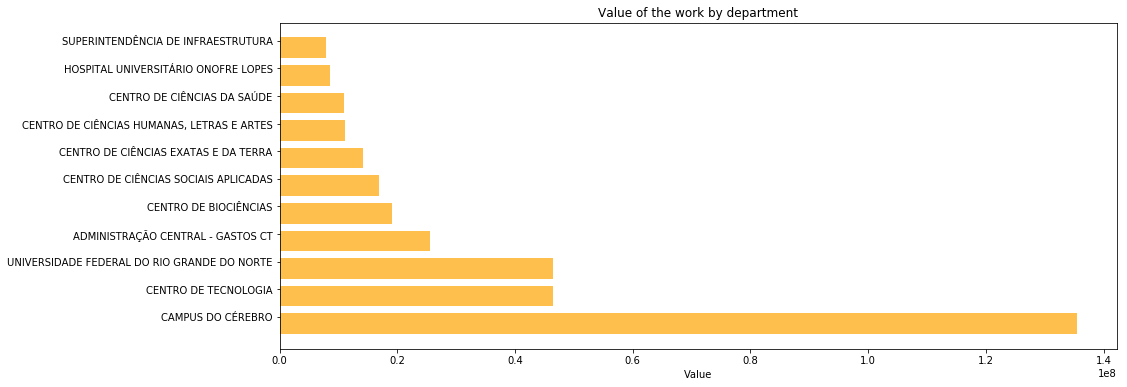

In [16]:
names = list(top11.keys())

fig, ax = plt.subplots(figsize=(15, 6))
bar_positions = np.arange(len(names)) + 0.75
xtick_pos = np.arange(len(names)) + 1
ax.set_yticks(xtick_pos)
ax.set_yticklabels(names)
ax.set_title('Value of the work by department')
ax.set_xlabel("Value")
ax.barh(bar_positions, list(top11.values()),0.75, color = 'orange', alpha = 0.7)
plt.show()

In [36]:
import plotly.plotly as py
import plotly.graph_objs as go

names = list(top11.keys())
values = list(top11.values())

trace1 = go.Bar(
    x = names,
    y = values,
    name='Money spent by departament',
     marker=dict(
        color=['rgba(222,45,38,0.8)', 'rgba(204,204,204,1)',
               'rgba(204,204,204,1)', 'rgba(204,204,204,1)',
               'rgba(204,204,204,1)', 'rgba(204,204,204,1)',
               'rgba(204,204,204,1)', 'rgba(204,204,204,1)',
               'rgba(204,204,204,1)', 'rgba(204,204,204,1)']),
    orientation='v'
)

data = [trace1]
layout = go.Layout(
    barmode='group',
    title='Money spent by departament',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='money_departament')

2.5 ) Oddly enough, the "Campus do Cérebro" costs a LOT more than the other departments,
the cell below shows the list of constructions made by that department

In [17]:
cerebro_list = []
for idx,rows in df.iterrows():
    if (rows['unidade_responsavel'] == campus_cerebro):
        cerebro_list.append(idx)
        
df.loc[cerebro_list]


,id_obra,descricao,periodo,qtd_dias,status_obra,licitacao,empresa,modalidade,valor,fonte_recurso,vigencia_projeto,projeto,id_unidade_responsavel,unidade_responsavel
33,5803,"execução, pela CONTRATADA, da CONSTRUÇÃO DO CE...",11/06/2010 - 22/12/2013,720,FINALIZADA,10/2009,86.712.247/0001-56 - EDCON - COMÉRCIO E CONST...,CONCORRÊNCIA,75574557.43,TESOURO - EDUCAÇÃO (112000000),NaN,NaN,5229.0,CAMPUS DO CÉREBRO
34,5810,CONSTRUÇÃO DA ESCOLA LYGIA MARIA ROCHA LEÃO LA...,14/06/2010 - 31/12/2011,565,FINALIZADA,10/2009,86.712.247/0001-56 - EDCON - COMÉRCIO E CONST...,CONCORRÊNCIA,59817003.64,NaN,17/12/2007 - 31/07/2013,FUNPEC/UFRN CONV. 147/2007 - CAMPUS DO CEREBRO...,5229.0,CAMPUS DO CÉREBRO
250,6814,EXECUÇÃO DE SERVIÇOS DE ARQUITETURA VISANDO À ...,09/05/2011 - 09/11/2012,550,CONTRATO FINALIZADO,1/2011,01.641.113/0001-39 - J. GALBINSK & CIA LTDA.,INEXIGIBILIDADE DE LICITAÇÃO,35899.28,NaN,01/01/2000 - 31/12/2015,MANUTENCAO II (1512001),5229.0,CAMPUS DO CÉREBRO


In [18]:
cc_describe = df.loc[cerebro_list]
print(cc_describe.iloc[0]['descricao'])
print(cc_describe.iloc[1]['descricao'])

execução, pela CONTRATADA, da CONSTRUÇÃO DO CENTRO DE PESQUISAS, LOCALIZADO NO CAMPUS DO CÉREBRO NA ESCOLA AGRÍCOLA DE JUNDIAÍ - MUNICÍPIO DE MACAÍBA / RN: conforme especificações, anexas a CONCORRÊNCIA Nº 10/2009-DMP.
	Unidade 01 - CONSTRUÇÃO DA ESCOLA LYGIA MARIA ROCHA LEÃO LAPORTA
	 Unidade 02 -  CONSTRUÇÃO DO CENTRO DE PESQUISAS


CONSTRUÇÃO DA ESCOLA LYGIA MARIA ROCHA LEÃO LAPORTA, LOCALIZADO NO CAMPUS DO CÉREBRO NA ESCOLA AGRÍCOLA DE JUNDIAÍ - MUNICÍPIO DE MACAÍBA/RN.


The cell above shows us that the **huge** expenses made by the *"Campus do Cérebro"* actually are for it's own construction, which of course would be expensier if compared to remodelling. Since this dataset dates only from 2005, and at that time most of the central campus had already been made, this huge gap between costs becomes more understandable.

Oddly enough the "Instituto metrópole digital"(IMD) isn't on the dataset

2.6 ) Disparity in the analysis of values **without** the Campus do Cérebro (Brain Campus)

With this chart we can better analyze how the investments in each unit are established

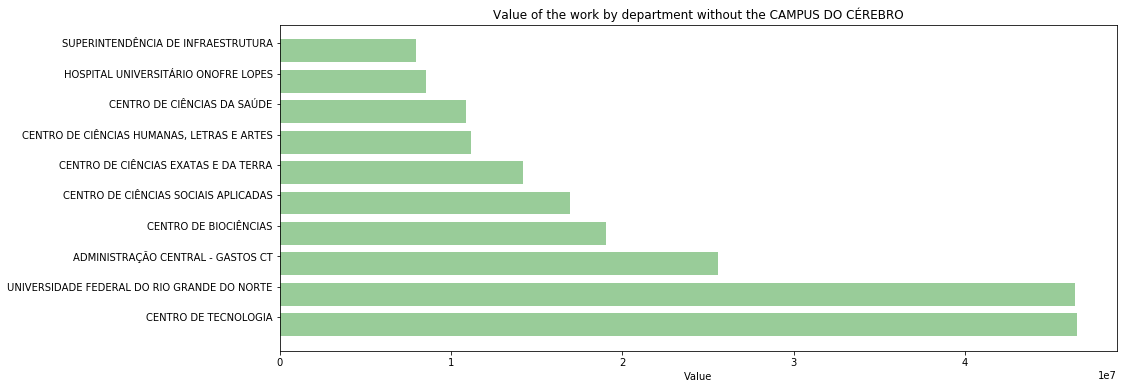

In [19]:
names = list(top10.keys())

fig, ax = plt.subplots(figsize=(15, 6))
bar_positions = np.arange(len(names)) + 0.75
xtick_pos = np.arange(len(names)) + 1
ax.set_yticks(xtick_pos)
ax.set_yticklabels(names)
ax.set_title('Value of the work by department without the CAMPUS DO CÉREBRO')
ax.set_xlabel("Value")
ax.barh(bar_positions, list(top10.values()),0.75 , color = 'green', alpha = 0.4)
plt.show()

In [37]:
import plotly.plotly as py
import plotly.graph_objs as go

names = list(top10.keys())
values = list(top10.values())

trace1 = go.Bar(
    x = names,
    y = values,
    name='Money spent by departament, without CAMPUS DO CÉREBRO',
    orientation='v'
)

data = [trace1]
layout = go.Layout(
    barmode='group',
    title='Money spent by departament, without CAMPUS DO CÉREBRO',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='money_departament')

## Analyzing Works Times
On the next cells, we will check, respectively, a construction's minimun time, max time and the mean of all these times.

### 3 )  The fastest work

3.1 ) This cell creates 2 variables, one containing the minimun value and the other it's index.

In [20]:
works_min_time = works['qtd_dias'].min()
works_min_index_time = works['qtd_dias'].idxmin()

# Then, we print to observe it's values and costs.
print("The fastest work took",works_min_time,"days")
print("It also cost", works.iloc[works_min_index_time]['valor'])
pd.DataFrame(works.iloc[works_min_index_time])

The fastest work took 5 days
It also cost R$         8.320,70


,245
id_obra,2849
descricao,RECUPERAÇÃO DE ENLACE ÓPTICO NA AV. RODRIGUES ...
periodo,15/01/2007 - 19/01/2007
qtd_dias,5
status_obra,FINALIZADA
licitacao,585/2006
empresa,01.009.821/0001-51 - PROTELE ENGENHARIA LTDA
modalidade,DISPENSA DE LICITAÇÃO
valor,"R$ 8.320,70"
fonte_recurso,UNIV.FEDERAL DO RIO GRANDE DO NORTE (250154214)


### 4 ) The slowest work

4.1 ) This cell creates 2 variables, one containing the maximun value and the other it's index.

In [21]:
works_max_time = works['qtd_dias'].max()
works_max_index_time = works['qtd_dias'].idxmax()

# Then, we print to observe it's values and costs.
print("The slowest work took",works_max_time,"days")
print("It also cost", works.iloc[works_max_index_time]['valor'])
pd.DataFrame(works.iloc[works_max_index_time])

The slowest work took 1306 days
It also cost R$       272.555,36


,557
id_obra,5931
descricao,O PRESENTE CONTRATO TEM COMO OBJETO A EXECUÇÃO...
periodo,15/07/2007 - 09/08/2011
qtd_dias,1306
status_obra,FINALIZADA
licitacao,4/2010
empresa,05.937.949/0001-36 - ATUAL ENGENHARIA E SERVI...
modalidade,TOMADA DE PREÇO
valor,"R$ 272.555,36"
fonte_recurso,TESOURO - EDUCAÇÃO (112000000)


In [22]:
works_mean_time = works['qtd_dias'].mean()
print( int(works_mean_time),"is the mean amount of days taken to finish a construction on UFRN")

185 is the mean amount of days taken to finish a construction on UFRN


### 5 ) Considerations
After our analysis over times, we concluded that UFRN actually takes approximately 6 months for a construction to be finished.

In [23]:
less_than_mean = 0
for i in works.qtd_dias:
    if i < works_mean_time:
        less_than_mean = less_than_mean + 1
        
amount_works = len(works.id_obra)
print(less_than_mean)
print(int (less_than_mean*100/amount_works),"%")

# Most of works done on UFRN are faster than the mean time.

513
60 %


In [62]:
qnt_dias = works['qtd_dias']
costs = works['valor'].sort_values()

# Create a trace
trace = go.Scatter(
    x = qnt_dias,
    y = costs,
    mode = 'markers'
)

data = [trace]

layout = go.Layout(
    title='Cost VS Work Days',
)
fig= go.Figure(data=data, layout=layout)
# Plot and embed in ipython notebook!
py.iplot(fig, filename='cost_vs_days', layout=layout)


### 6 ) Information on Requested Works

6.1 ) Following we will start our abstractions over the requested works of UFRN's departments.

For example, as we can see on the next cell, the department that made more requests is SuperIntendencia de Infraestrutura. 

In [24]:
# Saving the 5 most requests values.
five_most_1 = work_requests['nome_unidade_requisitante'].value_counts()[0]
five_most_2 = work_requests['nome_unidade_requisitante'].value_counts()[1]
five_most_3 = work_requests['nome_unidade_requisitante'].value_counts()[2]
five_most_4 = work_requests['nome_unidade_requisitante'].value_counts()[3]
five_most_5 = work_requests['nome_unidade_requisitante'].value_counts()[4]

# SuperIntendencia de Infraestrutura has more than double requests than the second most requester(Residencias Universitárias).
pd.DataFrame(work_requests['nome_unidade_requisitante'].value_counts()[:10])


,nome_unidade_requisitante
SUPERINTENDÊNCIA DE INFRAESTRUTURA,506
RESIDENCIAS UNIVERSITÁRIAS,225
UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE,186
CENTRO DE BIOCIÊNCIAS,162
PRÓ-REITORIA DE ADMINISTRAÇÃO (PROAD),160
DIRETORIA DE OBRAS,147
CENTRO DE CIÊNCIAS DA SAÚDE,134
HOSPITAL UNIVERSITÁRIO ONOFRE LOPES,134
DIREÇÃO DO CCSA,129
ESCOLA AGRÍCOLA DE JUNDIAÍ,119


6.2 ) Difference between amount of requests  

To better visualize the difference between amount of requests, we shall plot a graphic on bars for compare. This bar plot shows the 5 departments that requested the most for works. It makes obvious that 'SuperIntendência de Infraestrutura' made lots of requests, specially if compared with the others from the top 5.

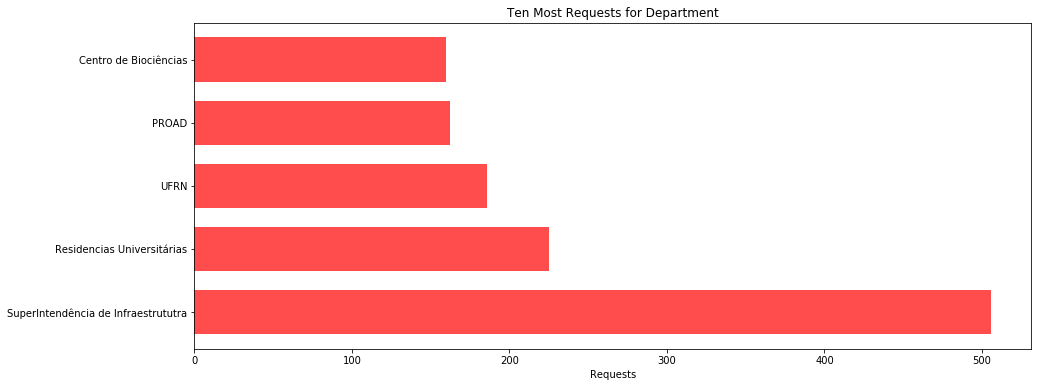

In [25]:
# Create a subplot that returns both figure and axis.
fig, ax = plt.subplots(figsize=(15, 6))

# Imported function from numpy to set axis positions.
from numpy import arange
bar_positions = arange(5) + 1

# Define x_ticks, which represents each bar and it's titles.
tick_positions = range(1,6)
ax.set_title("Ten Most Requests for Department")
ax.set_yticks(tick_positions)
#ax.set_xticks("# Requests")
ax.set_xlabel("Requests")
#ax.set_ylabel(tick_positions)

x_names = ['SuperIntendência de Infraestrututra', 'Residencias Universitárias', 'UFRN', 'PROAD', 'Centro de Biociências']
ax.set_yticklabels(x_names)

# Give to bars the respectively amount of requests from each department.
num_cols = [five_most_1, five_most_2, five_most_3, five_most_4, five_most_5]
bar_heights = num_cols
ax.barh( bar_positions, bar_heights, 0.7, color = 'red', alpha = 0.7)
plt.show()

In [26]:
from IPython.display import IFrame
IFrame(src="//plot.ly/~ozielalves/4.embed", width="100%", height="650px", frameBorder="0")

In [32]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x = ['SuperIntendência de Infraestrututra', 'Residencias Universitárias', 'UFRN', 'PROAD', 'Centro de Biociências'],
    y = [five_most_1, five_most_2, five_most_3, five_most_4, five_most_5],
    name='Top Five Requester Departaments',
    orientation='v'
)

data = [trace1]
layout = go.Layout(
    barmode='group',
    title='Top Five Requester Departaments',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

## Working with *Values*

In this part we will show in numbers and compare the values of the works with the nature of the requests.

### 7 ) Most expensive Work
The most expensive work was on Campus do Cérebro, researching about it we found that the Campus is located in Macaiba. According to the work description, the money was invested in the construction of the Lygia Maria Rocha Leão Laporta school and in the construction of the Search center. Because it is a project of an environment of academic studies focused on the neurological medical area it is justified the cost of about 76 million reais, The work took 2 years to finish. 

7.1 ) This cell shows in detail the two works carried out on the Campus do Cérebro.

In [0]:
cerebro_list = []
CT_list = []
for idx,rows in df.iterrows():
    if (rows['unidade_responsavel'] == CT):
        CT_list.append(idx)
    elif (rows['unidade_responsavel'] == campus_cerebro):
        cerebro_list.append(idx)
        
df.loc[cerebro_list]

7.2 ) This cell shows a Picture of the Campus do Cérebro during the construction

In [0]:
import tkinter as tk
root = tk.Tk()

imagem = tk.PhotoImage(file = "campus_cerebro.png")
w = tk.Label(root, image=imagem)
w.imagem = imagem
w.pack()

root.mainloop()

7.3 ) Here we use the data to find the most expensive done or in progress work

In [0]:
most_exp_work = works['valor'].max()

this = 0

print("The most expensive work cost was:", most_exp_work)

for i,valor in enumerate(works['valor']):
    if(valor == most_exp_work):
        this = i    
        
print("Work: ", works['unidade_responsavel'][this])        
print("\nDescription: ", works['descricao'][this])

pd.DataFrame(works.iloc[this])

### 8 ) Cheaper Work
Strangely the cheapest work that appears in the data cost only R$ 1,00, which seems quite out of the standards found in the data frame. the work was requested by UFRN and as it is explicit in the work's description.

The value was designated to the construction of civil works of the Pilot Research Center of the International Institute of Neurosciences, name that is given to one of the main constructions of the Campus do Cérebro(Brain Campus), which does not seem to be a coincidence.

In [0]:
most_cheap_work = works['valor'].min()

print("The most cheap work cost was:", most_cheap_work)

this = 0

for i,valor in enumerate(works['valor']):
    if(valor == most_cheap_work):
        this = i
        
print("Work: ", works['unidade_responsavel'][this])
print("\nDescription: ", works['descricao'][this])

pd.DataFrame(works.iloc[this])

### 9 ) Work requests per year

9.1 ) We can see that 2012 was a year of many applications, which almost lost to 2011. But what we can observe is that both annual ranges are within the data range of the Brain Campus as seen in topic 2.3.

In [0]:
years = work_requests.copy()
yr = work_requests['ano'].value_counts()

print("Works per year:")
yea = pd.DataFrame(yr)
yea.head()

9.2 ) The chart can help us see the divergence in the number of requests for works over the years. Note the peaks in the years 2011 and 2012.

In [0]:
work_requests.plot(kind='hist', y = 'ano', bins=30, figsize=(15,8), color = 'purple', alpha=0.3)
plt.xlabel('Years')
plt.title("Request per Year")
plt.show()

### 10 ) Work requests status 

10.1 ) We can see that most of the requests had their projects sent or were answered.

In [0]:
status = work_requests.copy()
sta = work_requests['status'].value_counts()

print("The work requests number by status:")

stat = pd.DataFrame(sta)
soma_fim = stat[stat.index.str.contains('FINALIZADA')].sum()
soma_pend = stat[stat.index.str.contains('PENDENTE')].sum()
stat.loc['FINALIZADAS'] = [soma_fim['status']]
stat.loc['PENDENTE AUTORIZAÇÃO'] = [soma_pend['status']]
pure_stat = stat.drop(index = ['FINALIZADA_ATENDIMENTO','FINALIZADA'])
final_stat = pure_stat.drop(index = ['ENVIADA_LICITACAO','AUTORIZADA PELO CHEFE DA UNIDADE','CADASTRADA',
                            'ENVIADA','RETORNADA','ATENDIDA_LICITACAO','AUTORIZADA PARA INFRA',
                            'AUTORIZADA DIREÇÃO CENTRO','AUTORIZADA PARA LICITAÇÃO',
                            'PENDENTE AUTORIZAÇÃO CHEFE UNIDADE','PENDENTE AUTORIZAÇÃO CHEFIA'])

porce = final_stat/pure_stat.sum()*100
porce

10.2 ) We calculated the percentage of request statuses to better understand data statistics.

In [0]:
explode = (0.1, 0.1, 0.1, 0.1, 0.3, 0.1, 0.1, 0.1, 0.3, 0.1)
labels = porce.index
fig = plt.figure(figsize=(15,8))
plt.pie(porce, explode=explode, autopct='%1.1f%%',shadow=True, startangle=30, radius=0.9)
plt.axis('equal')
plt.legend(loc='best',labels=labels, bbox_to_anchor=(-0.1,0.6))
plt.title("Work Requests Status")
plt.show()

In [0]:
import plotly.plotly as py
import plotly.graph_objs as go

fig = {
  "data": [
    {
      "values": porce.values,
      "labels": ["Projetos Enviados", "Solicitações Atendidas", "Finalizadas", "Arquivados",
       "Orçamento Enviado", "Negados", "Estornados", "Autorização Pendente",
       "Aguardando Execução", "Autorizadas"],
      "domain": {"column": 0},
      "name": "Work Requests Status",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Work Requests Status",
        "grid": {"rows": 1, "columns": 2},
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Status",
                "x": 0.20,
                "y": 0.5
            },
        ]
    }
}
py.iplot(fig, filename='donut')